<h4>References: </h4>

1)  https://mathlang.hatenablog.com/entry/2018/10/19/070000

<h4>Advection diffusion equation</h4>
<h4 >1. Mathematical form : </h4>
<h4>$\frac{\partial u}{\partial t}+\nabla \cdot(\boldsymbol{c} u)=\nabla \cdot(D \nabla u)\hspace{4mm}(1)$</h4>
<h4 >2. Simplified form : </h4>
<h4>With c and D constant, one dimension</h4>
<h4>$ \frac{\partial{u}}{\partial{t}}+ c\frac{\partial{u}}{\partial{x}} = D\frac{\partial^2{u}}{\partial x^2} \hspace{4mm}(2)$</h4>

<h4 >3. Initial conditions : </h4>
<h4>$
u(x,0)=\left\{\begin{matrix}
2&x\in[1,4]\\
1&x\in[0,1)\cup(4,40]
\end{matrix}\right.$   
</h4>
<h4>$c=1.2, D=0.2$</h4>
<h4>4. Analytical solution:</h4>

</h4>$u(t, x)=\frac{1}{\sqrt{4 D t \pi}} \int_{-\infty}^{\infty} u(s,0) e^{-\frac{(x-ct-s)^2}{4 D t}} ds \hspace{4mm}(3)$</h4>

In [21]:
import tensorflow as tf
from tensorflow import keras

import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.animation as animation

from IPython.display import HTML

In [22]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    for device in physical_devices:
        print("GPU Device:", device)

Num GPUs Available:  1
GPU Device: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


<h4>Build analytical solution</h4>
The analytical solution is an integral and can only be solved when $u(s,0)$ is given with a comfortable value. The analytical solution can also be written as a sum of infinite terms. Most of the time simulation is the only method for advection diffusion and even when the integeral can be solved somehow, it may also prefer to be done by a computer.

In [29]:
c = 1.0
d = 0.18
deltat = 0.04
deltax = 0.2
t = 14
L = 40

nt = int(t/deltat)
nx = int(L/deltax)

x = np.linspace(0, L, nx)

In [213]:
import scipy.integrate as spi

k = np.where((x < 1) | (x >4), 0.0, 2.0)

lower = 0
upper = 40

def u_initial(s):
    x = s
    return np.where((x < 1) | (x > 4), 0.0, 2.0)


def calculate_u(x, t):
    def integrand(s):
        return u_initial(s) * np.exp(-((x -c* t - s) ** 2) / (4 * d* t)) 
    
    result, _ = spi.quad(integrand, lower, upper)
    u_tx = result / np.sqrt(4 * d * t * np.pi)
    return u_tx

x_value = 2.1
t_value = 0.01 # to avoid 0 to be divided
u_result = calculate_u(x_value, t_value)

In [214]:
u_result # close to 2, this can be thought to be close to analytical solution

2.000000000000095

In [215]:
import datetime

start_time_analytical = datetime.datetime.now()
analytical = []

for i in range(nt):
    kn = k.copy()
    analytical.append(kn)
    for n in range(nx):
        k[n] = calculate_u(n * deltax + 0.01, i * deltat + 0.01)# to avoid 0 to be divided
        
end_time_analytical = datetime.datetime.now()     
# This is super time consuming        

In [1]:
#elapsed_time_analytical = end_time_analytical - start_time_analytical
#plt.plot(x,analytical[-1], label="last time analytical")
#plt.text(1.0,1.1, f"Analytical: {elapsed_time_analytical.total_seconds():.6f} s", fontsize=12, ha='center', va='center', bbox=dict(facecolor='white', edgecolor='gray', boxstyle='round,pad=0.4'))
#plt.grid()
#plt.legend()
#plt.show()

<h4>Simulations</h4>
<h4>1. Upwind differencing(Backward differencing) :</h4>
The left side of the equation is just advection, the difference approximation is listed in my advection notebook.To calculate the right side, one can perform backward Euler method $\frac{\mathrm{d}^2 u}{\mathrm{~d} x^2}=\frac{\mathrm{d}\left(\frac{\mathrm{d} u}{\mathrm{~d} x}\right)}{\mathrm{d} x} \simeq \frac{\frac{u_{i+1} -u_i}{\Delta x}-\frac{u_i-u_{i+1}}{\Delta x}}{\Delta x}=\frac{u_{i+1}+u_{i-1}-2 u_i}{\Delta x^2}$ on $D\frac{\partial^2{u}}{\partial x^2}$. This yields
<h3>$ \frac{u_i^{n+1}-u_i^n}{\Delta t} +c\frac{u_i^n-u_{i-1}^n}{\Delta x} = D\frac{u^n_{i+1}-2u^n_i+u^n_{i-1}}{(\Delta x)^2}
\hspace{4mm}(1)$</h3>

Substituting$ \frac{c \Delta t}{\Delta x} $for $\alpha $ and $D\frac{\Delta t}{(\Delta x)^2}$for $\beta$ leads to
<h3>$ u_i^{n+1} = u_i^n -\alpha(u_i^n-u_{i-1}^n) + \beta( u^n_{i+1}-2u^n_i+u^n_{i-1})
\hspace{4mm}(2)$</h3>

<h4> Courant condition: $\alpha = \frac{c \Delta t}{\Delta x} < 1 $ and $ \Delta t \leqq \frac{\Delta x^2}{2D}  $ </h4>
<h3>$ u_i^{n+1} = (1-\alpha)u_i^n +\alpha u_{i-1}^n
\hspace{4mm}(4)$</h3>

In [172]:
# Courant condition test
if c*deltat/deltax >= 1 or deltat > deltax**2/(2*d):
    print("Error Courant condition failed")
else:
    print("Courant condition past, expecting steady simulation")
    

Courant condition past, expecting steady simulation


In [192]:
start_time_Upwind = datetime.datetime.now()

keep1 = []

u = np.where((x < 1) | (x >4), 0.0, 2.0)
alpha = c*deltat/deltax
beta = d*deltat/(deltax**2)

for n in range(nt): 
    un = u.copy()
    keep1.append(un)
    for i in range(1, nx-1):
        u[i] = un[i] - alpha * (un[i] - un[i-1]) + beta *(un[i+1] -2*un[i]+un[i-1])

end_time_Upwind = datetime.datetime.now()

In [2]:
#plt.plot(x,keep1[-1], label="last time Upwind")
#elapsed_time_Upwind = end_time_Upwind - start_time_Upwind
#plt.text(1.0,1.1, f"Upwind: {elapsed_time_Upwind.total_seconds():.6f} s", fontsize=12, ha='center', va='center', bbox=dict(facecolor='white', edgecolor='gray', boxstyle='round,pad=0.4'))
#plt.grid()
#plt.xlabel("x")
#plt.ylabel("y")
#plt.legend()
#plt.show()

<h4>1. Crank-Nicolson :</h4>
Crank-Nicolson uses a second-order method in time
The first term on the left side follows backward Euler method : $\frac{\partial u}{\partial t} = c\frac{u_i^n-u_{i-1}^n}{\Delta x}$

The second term on the left side uses a second-order method in time, taking the average between time $n+1$ and $n$ : $ c \frac{\partial u}{\partial x} = \frac{c}{2}\frac{u^{n+1}_{i+1} - u^{n+1}_{i-1}}{2\Delta x} + \frac{u^n_{i+1}-u^n_{i-1}}{2\Delta x}$

The right side of the equation also takes a second-order method in time: $D\frac{\partial^2{u}}{\partial x^2} = \frac{D}{2} \left( \frac{u^{n+1}_{i+1} - 2u^{n+1}_{i} + u^{n+1}_{i-1} }{\Delta x^2} + \frac{u^{n}_{i+1} - 2u^{n}_{i} + u^{n}_{i-1} }{\Delta x^2} \right)$

Substuting the approximations into advection diffusion equation yiels:

<h3>$ \frac{u_i^{n+1}-u_i^n}{\Delta t} + \frac{c}{2}\left( \frac{u^{n+1}_{i+1} - u^{n+1}_{i-1}}{2\Delta x} + \frac{u^n_{i+1}-u^n_{i-1}}{2\Delta x} \right)= \frac{D}{2} \left( \frac{u^{n+1}_{i+1} - 2u^{n+1}_{i} + u^{n+1}_{i-1} }{\Delta x^2} + \frac{u^{n}_{i+1} - 2u^{n}_{i} + u^{n}_{i-1} }{\Delta x^2} \right)\hspace{4mm}(1)$</h3>

Substituting$ \frac{c \Delta t}{4\Delta x} $for $\theta $ and $ D\frac{\Delta t}{2(\Delta x)^2}$for $\phi$ yields
<h3>$ u_i^{n+1}-u_i^n + \theta \left( u^{n+1}_{i+1} - u^{n+1}_{i-1} + u^n_{i+1}-u^n_{i-1} \right)= \phi \left( u^{n+1}_{i+1} - 2u^{n+1}_{i} + u^{n+1}_{i-1}  + u^{n}_{i+1} - 2u^{n}_{i} + u^{n}_{i-1} \right)\hspace{4mm}(2)$</h3>

To perform matrix calculations, transform all terms of $u^{n+1}$ to the left side and $u^{n}$ to the right side

$ -(\phi+\theta)u_{i-1}^{n+1} + (1+2\phi)u_{i}^{n+1} -(\phi -\theta)u_{i}^{n+1} = (\phi+\theta)u_{i-1}^n +(1-2\phi)u_i^n+(\phi-\theta)u_{i+1}^n \hspace{4mm}(3)$

This can be derived into a matrix equation

\begin{array}
$\begin{bmatrix}
  (1+2\phi) & -(\phi-\theta) & 0 & 0 & \dots & 0\\
  -(\phi+\theta) & (1+2\phi) & -(\phi-\theta) & 0 & \dots & 0\\
  0 & -(\phi+\theta) & (1+2\phi) & -(\phi-\theta) & \dots & 0\\
  \vdots & \vdots & \vdots &  \vdots & \ddots & \vdots\\
  0 & 0 & \dots & -(\phi + \theta) &(1+2\phi) &-(\phi - \theta)
\end{bmatrix}
\begin{bmatrix}
u_0^{n+1}\\
u_1^{n+1}\\
u_2^{n+1}\\
\vdots\\
u_i^{n+1}\\
\end{bmatrix}
\begin{matrix}
=
\end{matrix}
\begin{bmatrix}
  (1-2\phi) & (\phi-\theta) & 0 & 0 & \dots & 0\\
  (\phi+\theta) & (1-2\phi) & (\phi-\theta) & 0 & \dots & 0\\
  0 & (\phi+\theta) & (1-2\phi) & (\phi-\theta) & \dots & 0\\
  \vdots & \vdots & \vdots &  \vdots & \ddots & \vdots\\
  0 & 0 & \dots & (\phi + \theta) &(1-2\phi) &(\phi - \theta)
\end{bmatrix}
\begin{bmatrix}
u_0^{n}\\
u_1^{n}\\
u_2^{n}\\
\vdots\\
u_i^{n}\\
\end{bmatrix}
\begin{matrix}
\hspace{4mm}(4)
\end{matrix}
\end{array}


In [178]:
start_time_Crank_Nicolson = datetime.datetime.now()

theta = c*deltat/(4*deltax)
phi = d*deltat/(2*deltax**2)

u = np.where((x < 1) | (x >4), 0.0, 2.0)
A = np.zeros((nx+1, nx+1))
B = np.zeros((nx+1, nx+1))

for i in range(1, nx):
    A[i, i-1] = -phi - theta
    A[i, i] = 1 + 2*phi
    A[i, i+1] = - ( phi - theta)

    B[i, i-1] = phi + theta
    B[i, i] = 1 - 2*phi
    B[i, i+1] = phi - theta
# Au_new = Bu_old
# calculate with np.linalg.solve(A, right_side)
    
u_new = u.copy()
keep2 = []
for n in range(nt):
    u_new[1:nx] = np.linalg.solve(A[1:nx, 1:nx], np.dot(B[1:nx, 1:nx], u[1:nx]))
    keep2.append(u_new.copy())
    u = u_new
end_time_Crank_Nicolson = datetime.datetime.now()

In [3]:
#plt.plot(x,keep2[-1], label="last time Crank-Nicolson")
#elapsed_time_Crank_Nicolson = abs(end_time_Crank_Nicolson - start_time_Crank_Nicolson)
#plt.text(1.0,1.1, f"Crank-Nicolson: {elapsed_time_Crank_Nicolson.total_seconds():.6f} s", fontsize=12, ha='center', va='center', bbox=dict(facecolor='white', edgecolor='gray', boxstyle='round,pad=0.4'))
#plt.grid()
#plt.xlabel("x")
#plt.ylabel("y")
#plt.legend()
#plt.show()

In [78]:
def MLP(n_input1, n_input2, n_output, n_neuron, n_layer, act_fn):
    input1 = keras.layers.Input(shape=(n_input1,))
    input2 = keras.layers.Input(shape=(n_input2,))

    
    merged = keras.layers.concatenate([input1, input2])
    hidden_layers=[]
    
    for _ in range(n_layer):
        hidden = keras.layers.Dense(
            units=n_neuron,
            activation=act_fn,
            kernel_initializer=tf.keras.initializers.GlorotNormal())
        hidden_layers.append(hidden)
        
    for hidden in hidden_layers:
            merged = hidden(merged)
        
    
    output = keras.layers.Dense(
            units=n_output,
            activation="elu",
            kernel_initializer=tf.keras.initializers.GlorotNormal()
            )(merged)
    
    model = tf.keras.models.Model(inputs=[input1, input2], outputs=output)    

    return model

class EarlyStopping:

    def __init__(self, patience=10, verbose=0):
        self.stopped = 0
        self.epoch = 0 
        self.pre_loss = float('inf') 
        self.patience = patience
        self.verbose = verbose # 早期終了メッセージの出力フラグをパラメーターで初期化

    def __call__(self, current_loss):

        if self.pre_loss <= current_loss: 
            self.epoch += 1 

            if self.epoch > self.patience:
                self.epoch = 0
                self.pre_loss = current_loss 
                return True

        else: 
            self.epoch = 0 
            self.pre_loss = current_loss 

        return False


class PhysicsInformedNNs():

    def __init__(self, n_input1,n_input2, n_output, n_neuron, n_layer, epochs, act_fn='tanh'):
        self.n_input1 = n_input1
        self.n_input2 = n_input2
        self.n_output = n_output
        self.n_neuron = n_neuron
        self.n_layer = n_layer
        self.epochs = epochs
        self.act_fn = act_fn
        self.loss_loc = []
        self.batch = []
        self.min_learning_rate = 1.0e-7

    def build(self, optimizer, loss_fn, early_stopping, factor):
        self._model = MLP(self.n_input1,self.n_input2, self.n_output, self.n_neuron, self.n_layer, self.act_fn)
        self._optimizer = optimizer
        self._loss_fn = loss_fn
        self._early_stopping = early_stopping
        self.factor = factor
        return self

    def train_step(self, t_data1,x_data1, u_data1,t_data2,x_data2,u_data2, t_pinn,x_pinn, d,c,loop):
        with tf.GradientTape() as tape_total:
            tape_total.watch(self._model.trainable_variables)
            u_pred_1 = self._model([t_data1, x_data1])
            u_pred_2 = self._model([t_data2, x_data2])
            loss1_1 = 0.005*self._loss_fn(u_pred_1, u_data1)
            loss1_2 = 0.8*self._loss_fn(u_pred_2, u_data2)
            loss1 = loss1_1 + loss1_2
            loss1 = tf.cast(loss1, dtype=tf.float32)
            
            with tf.GradientTape() as tape1:  
                tape1.watch(t_pinn)
                u_pred_pinn = self._model([t_pinn, x_pinn])
            u_t = tape1.gradient(u_pred_pinn, t_pinn)
            
            with tf.GradientTape() as tape2:
                tape2.watch(x_pinn)
                with tf.GradientTape() as tape3:
                    tape3.watch(x_pinn)
                    u_pred_pinn = self._model([t_pinn, x_pinn])
                u_x = tape3.gradient(u_pred_pinn, x_pinn)
            u_xx = tape2.gradient(u_x, x_pinn)    

            u_t = tf.cast(u_t, dtype=tf.float32)
            u_x = tf.cast(u_x, dtype=tf.float32)
            u_xx = tf.cast(u_xx, dtype=tf.float32)

            loss_physics = u_t + c * u_x -d*u_xx
            loss2 = self._loss_fn(loss_physics, tf.zeros_like(loss_physics))
            loss2 = tf.cast(loss2, dtype=tf.float32)
         
            loss = loss1 + loss2 
            
        self._optimizer.minimize(loss, self._model.trainable_variables, tape=tape_total)
        self._loss_values.append(loss)
        
        if loop % 300 ==0:
            self.loss_loc.append(loss.numpy())
            self.batch.append(loop)
            print("loss1_1: ",loss1_1.numpy(),"loss1_2:", loss1_2.numpy(),"loss2: ",loss2.numpy(),"loss: ",loss.numpy(),  "train_step:",loop)
       # if loop % 500 == 0:
          #  u_pred_test = self._model([t_data1, x_data1])
           # plt.plot(x_data1, u_pred_test, label="loop{}".format(loop))
          #  plt.legend()
           # plt.grid()
           # plt.show()
        return self

    def train(self, t_data1, x_data1,u_data1,t_data2,x_data2,u_data2, t_pinn,x_pinn, d,c):
        self._loss_values = []
        self.loop = 0
        self.stopped = 0
        for i in range(self.epochs):
            self.loop += 1
            self.train_step(t_data1, x_data1,u_data1,t_data2,x_data2,u_data2, t_pinn,x_pinn, d,c, self.loop)
            if self._early_stopping(self._loss_values[-1]):
                self._optimizer.learning_rate.assign(self._optimizer.learning_rate * self.factor)
                print("current_learning_rate:" , self._optimizer.learning_rate)
                self.stopped +=1
                if self.stopped >20:
                    print("early stopping")
                    break
                else:
                    continue

In [81]:
# boundary condition
points = 200
x_pinn = np.array([np.linspace(0,L, points)]*points)
x_pinn = tf.reshape(x_pinn,[-1,1])

t_pinn = tf.linspace(0,t, points)
t_pinn = tf.reshape(t_pinn, [-1,1])
t_pinn = tf.tile(t_pinn, [1, points])
t_pinn = tf.reshape(t_pinn, [-1,1])
t_input = tf.linspace(0,t, nt)

x_starting_points = [i for i in range(nx)]
t_starting_points = [0]
u_starting_points = [i for i in range(nx)]


x_data1 = tf.gather(x, x_starting_points )
u = tf.where(((x_data1 <1 ) | ( x_data1 >4)), 0.0, 2.0)
x_data1 = tf.reshape(x_data1,[-1,1])
t_data1 = tf.zeros_like(x_data1)
u_data1 = tf.gather(u, u_starting_points)
# u_data1 = tf.reshape(u_data1 , [-1,1])

t_boundary_points = [i for i in range(nt)]

t_data2 = tf.gather(t_input, t_boundary_points)
x_data21= tf.zeros_like(t_data2)
x_data21 = tf.cast(x_data21, dtype=tf.float32) 
x_data22 = tf.fill(nt, 20.0)
x_data22 = tf.cast(x_data21, dtype=tf.float32) 
t_data2 = tf.concat([t_data2, t_data2], axis=0)
t_data2 = tf.reshape(t_data2, [-1,1])

x_data2 = tf.concat([x_data21, x_data22], axis=0)
x_data2 = tf.reshape(x_data2, [-1,1])
u_data2= tf.zeros_like(x_data2)
u_data2= tf.reshape(u_data2, [-1,1])

In [89]:
start_time_PINNs_training = datetime.datetime.now()
PINNs = PhysicsInformedNNs(1,1,1,72,5,18000)
optimizer = tf.keras.optimizers.Adam(learning_rate = 1.0e-2)
loss_fn = tf.keras.losses.MeanSquaredError()
early_stopping = EarlyStopping(patience=180,verbose=1)
PINNs.build(optimizer, loss_fn, early_stopping, 0.76)
PINNs.train( t_data1,x_data1, u_data1,t_data2,x_data2,u_data2, t_pinn,x_pinn, d,c)
end_time_PINNs_training = datetime.datetime.now()
elapsed_time_PINNs_training = abs(end_time_PINNs_training - start_time_PINNs_training)

loss1_1:  0.0006641238 loss1_2: 1.0551957e-05 loss2:  6.823929e-05 loss:  0.000742915 train_step: 300
loss1_1:  0.00021249811 loss1_2: 0.0003837192 loss2:  2.474245e-05 loss:  0.00062095973 train_step: 600
loss1_1:  0.00014437149 loss1_2: 6.273298e-05 loss2:  1.3703674e-05 loss:  0.00022080813 train_step: 900
loss1_1:  0.00012834613 loss1_2: 4.1020778e-07 loss2:  7.45126e-06 loss:  0.0001362076 train_step: 1200
loss1_1:  0.00012025824 loss1_2: 3.0216654e-07 loss2:  6.0648213e-06 loss:  0.00012662522 train_step: 1500
loss1_1:  0.00011438149 loss1_2: 7.274417e-07 loss2:  5.997018e-06 loss:  0.00012110595 train_step: 1800
loss1_1:  0.000114196155 loss1_2: 0.0006752106 loss2:  7.030345e-06 loss:  0.0007964371 train_step: 2100
loss1_1:  0.00010344561 loss1_2: 4.210335e-06 loss2:  5.8138125e-06 loss:  0.00011346975 train_step: 2400
loss1_1:  9.866213e-05 loss1_2: 0.00011770083 loss2:  5.8428823e-06 loss:  0.00022220585 train_step: 2700
loss1_1:  9.349193e-05 loss1_2: 8.140973e-05 loss2:  5.8

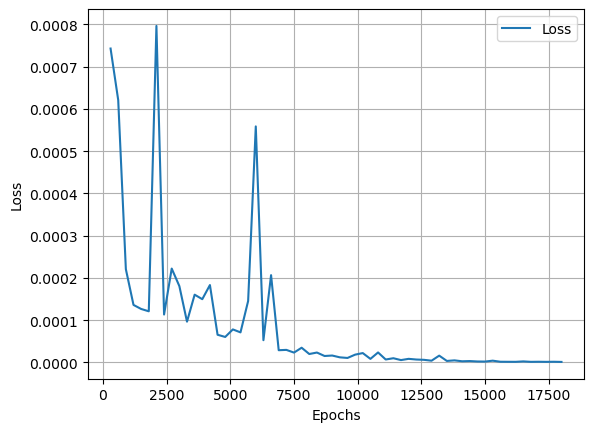

In [180]:
plt.plot(PINNs.batch,PINNs.loss_loc, label = "Loss")
plt.grid(True)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()
loss_loc1 = PINNs.loss_loc
batch1 = PINNs.batch

In [194]:
x_test = np.linspace(0,L,nx)
t_test = tf.linspace(0,t,nt)

u_pred=[]

for i in range(nt-1):
    tt = tf.fill(nx, t_test[i])
    u_pred.append(np.reshape(PINNs._model([tt,x_test]), (-1)))

In [195]:
start_time_PINNs_predicting = datetime.datetime.now()

u_pred.append(np.reshape(PINNs._model([tf.fill(nx, t_test[-1]), x_test]), (-1)))

end_time_PINNs_predicting = datetime.datetime.now()

elapsed_time_PINNs_predicting = abs(end_time_PINNs_predicting - start_time_PINNs_predicting)
elapsed_time_PINNs_training = abs(end_time_PINNs_training - start_time_PINNs_training)

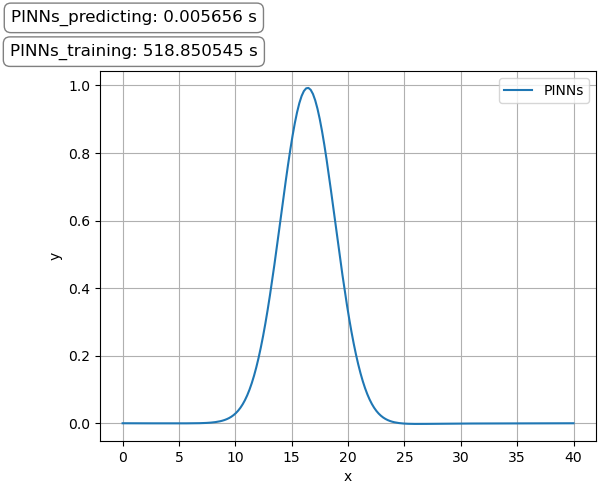

In [196]:
t_test = np.array([t] * nx)
t_test = tf.reshape(t_test, [-1,1])
u_last_time_PINNs = PINNs._model([t_test, x_test], (-1))
u_last_time_analytical = analytical[-1]

plt.plot(x_test, u_last_time_PINNs, label="PINNs")
plt.text(1.0,1.1, f"PINNs_training: {elapsed_time_PINNs_training.total_seconds():.6f} s", fontsize=12, ha='center', va='center', bbox=dict(facecolor='white', edgecolor='gray', boxstyle='round,pad=0.4'))
plt.text(1.0,1.2, f"PINNs_predicting: {elapsed_time_PINNs_predicting.total_seconds():.6f} s", fontsize=12, ha='center', va='center', bbox=dict(facecolor='white', edgecolor='gray', boxstyle='round,pad=0.4'))
plt.grid(True)
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()

In [197]:
t_test = np.array([t] * nx)
t_test = tf.reshape(t_test, [-1,1])
u_4sec = PINNs._model([t_test, x_test], (-1))

In [237]:
import pandas as pd
def calculate_mse(array1, array2):
    if len(array1) != len(array2):
        raise ValueError("Input arrays must have the same length.")
    
    squared_errors = (array1 - array2) ** 2
    mse = np.mean(squared_errors)
    return mse

mse_PINNs = calculate_mse(u_last_time_PINNs, u_last_time_analytical)
mse_Crank_Nicolson=calculate_mse(keep2[-1], u_last_time_analytical)
mse_Upwind=calculate_mse(keep1[-1], u_last_time_analytical)
data1 = {
    'Method': ['PINNs', 'Crank_Nicolson', 'Upwind'],
    'MSE': [mse_PINNs, mse_Crank_Nicolson, mse_Upwind],
}
data2= {
        "": ["PINNs_training", "PINNs_predicting", "Crank-Nicolson", "Upwind"],
        "Time": [elapsed_time_PINNs_training.total_seconds(), elapsed_time_PINNs_predicting.total_seconds(), elapsed_time_Crank_Nicolson.total_seconds(), abs(elapsed_time_Upwind.total_seconds())]
}

df1 = pd.DataFrame(data1)
df2 = pd.DataFrame(data2)
print(df1)
print(df2)


           Method       MSE
0           PINNs  0.165937
1  Crank_Nicolson  0.000021
2          Upwind  0.001958
                           Time
0    PINNs_training  518.850545
1  PINNs_predicting    0.005656
2    Crank-Nicolson    0.073665
3            Upwind    0.039319


4 seconds of moving is still not able to show the advantages of PINNs but it is powerful enough. Notice that the analytical solution it self is solved by Python and loss between the condition in real world inevitably happens.

(The analytical solution is an integral. Thus, I calculated analytical data with python as well. Considering the rounding errors, information loss errors, and intrinsic unavoidable errors , etc. Due to the method of computation, the MSE may not have much value. However, because Crank-Nicolson is almost the most precise method for advection diffusion's simulation, it is enough to observe that PINNs perform closely to Crank-Nicolson.)

Crank-Nicolson's time consuming problem has been discussed for long but a pretrained PINNs may have a chance to solve this problem

In [1]:
x = np.linspace(0, L, int(L / deltax))
def update_plot(num):
    
    ax.cla()
    
    ax.set_ylim(-0.1, 2.5)
    ax.plot(x, keep1[num], label="upwind(One order implicit Euler method)")
    ax.plot(x, analytical[num], label="analytical")
    ax.plot(x, keep2[num], label="Crank-Nicolson")
    ax.plot(x_test, u_pred[num], label="PINNs")
    ax.set_title('Fluid Flow Animation')
    ax.set_xlabel('x')
    ax.set_ylabel('u')
    ax.legend()
    ax.grid()


fig = plt.figure()
ax = fig.add_subplot()
ani = animation.FuncAnimation(fig, update_plot, frames=nt, interval=10)
ani.save("advection_diffusion.gif", writer="imagemagick")
plt.close()
HTML(ani.to_jshtml())

NameError: name 'np' is not defined

In [2]:
def calculate_loss(k1,k2,k3,ana,num):
    mse_Upwind_plot = calculate_mse(k1[num], ana[num])
    mse_Crank_Nicolson_plot = calculate_mse(k2[num], ana[num])
    mse_PINNs_plot = calculate_mse(k3[num], ana[num])

    return mse_Upwind_plot, mse_Crank_Nicolson_plot, mse_PINNs_plot

keeploss1 = [0]*nt
keeploss2 = [0]*nt
keeplossPINNs = [0]*nt
for i in range(nt):
    keeploss1[i], keeploss2[i], keeplossPINNs[i] = calculate_loss(keep1, keep2, u_pred, analytical, i)

t_space = np.linspace(0, t, nt)
def update_loss(num):
    ax.cla()
    
    ax.set_xlim(0.0, t)
    ax.set_ylim(0.0, 0.01)
    ax.plot(t_space[:num], keeploss1[:num], label="upwind(One order implicit Euler method)")
    ax.plot(t_space[:num], keeploss2[:num], label="Crank-Nicolson")
    ax.plot(t_space[:num], keeplossPINNs[:num], label="PINNs")
    ax.set_title('Fluid Flow Animation')
    ax.set_xlabel('t')
    ax.set_ylabel('Loss')
    ax.legend()
    ax.grid()
    
fig = plt.figure()
ax = fig.add_subplot()
ani = animation.FuncAnimation(fig, update_loss, frames=nt, interval=10)
ani.save("advection_diffusion_loss.gif", writer="imagemagick")
plt.close()
#HTML(ani.to_jshtml())    

NameError: name 'nt' is not defined

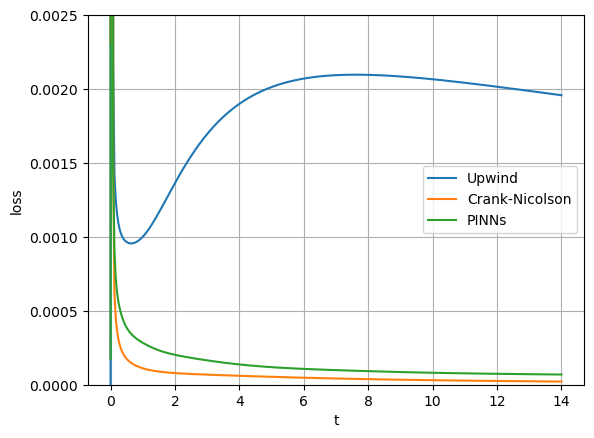

<Figure size 640x480 with 0 Axes>

In [236]:
t_space = np.linspace(0, t, nt)
plt.ylim(0.0, 0.0025)
plt.plot(t_space, keeploss1, label="Upwind")
plt.plot(t_space, keeploss2, label="Crank-Nicolson")
plt.plot(t_space, keeplossPINNs, label="PINNs")
plt.grid(True)
plt.legend()
plt.xlabel("t")
plt.ylabel("loss")
plt.show()
plt.savefig("advection_diffusion_loss_comparison.png")

In [4]:
#plt.ylim(0.7, 1.0)
#plt.xlim(15,19)
    #ax.plot(x_test, u_pred[num], label="PINNs")
#plt.plot(x, keep1[-1], label="upwind(One order implicit Euler method)")
#plt.plot(x, analytical[-1], label="analytical(calculated by python)")
#plt.plot(x, keep2[-1], label="Crank-Nicolson")
#plt.plot(x_test, u_pred[-1], label="PINNs")
#plt.title('Last time comparison')
#plt.xlabel('x')
#plt.ylabel('u')
#plt.legend()
#plt.grid()
#plt.savefig('advection_diffusion_last_time_comparison.png') 
#plt.show()

PINNs dont perform better than simulations, this may because that PINNs seem to oscillate on the initial condition, tackling the composition of Loss or use other method of training may help in this condition. However, as we already know the initial condition, we may use PINNs for temporal and spatial development and concatenate the already known initial condition to let the model make the most of advantages.

In [ ]:
# save the model
model_path = 'advection_diffusion_PINNs.h5'
PINNs._model.save(model_path)

#loaded_model = keras.models.load_model(model_path)

#t_test = np.linspace(0, 1, 100)
#x_test = np.linspace(0, 1, 100)
#t_test, x_test = np.meshgrid(t_test, x_test)
#u_pred = loaded_model.predict([t_test.flatten(), x_test.flatten()])
#u_pred = u_pred.reshape(t_test.shape)




